# Part 1: Download data
- Download data with kaggle API
- Unzip data file
- Data Exploration

In [1]:
# Import libs
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

In [2]:
# # Setting for kaggle api
# import os
# os.environ['KAGGLE_USERNAME'] = 'myname' # username
# os.environ['KAGGLE_KEY'] = 'mykey' # key

In [3]:
# !kaggle datasets download -d arunrk7/surface-crack-detection

In [4]:
# # Create a ZipFile Object and load sample.zip in it
# with ZipFile('surface-crack-detection.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

In [5]:
neg_img_paths = glob('./Negative/*.jpg')
pos_img_paths = glob('./Positive/*.jpg')
print("Total negative images:", len(neg_img_paths))
print("Total positive images:", len(pos_img_paths))

Total negative images: 20000
Total positive images: 20000


In [6]:
# helper function for conver img to numpy array
def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64, 64))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

In [7]:
# helper function for plot two set of imgs for comparision
def plot_two_pic_set(s1,s2,n=8,img_shape = (64,64,3)):

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(s1[i].reshape(*img_shape ))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        
        # display reconstruction
        ax = plt.subplot(3, n, i+n+1)
        plt.imshow(s2[i].reshape(*img_shape))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

In [8]:
neg_img_list = img_to_np(neg_img_paths[:1000])
pos_img_list = img_to_np(pos_img_paths[:1000])

First row for normal imgs 
Second row for cracked  imgs


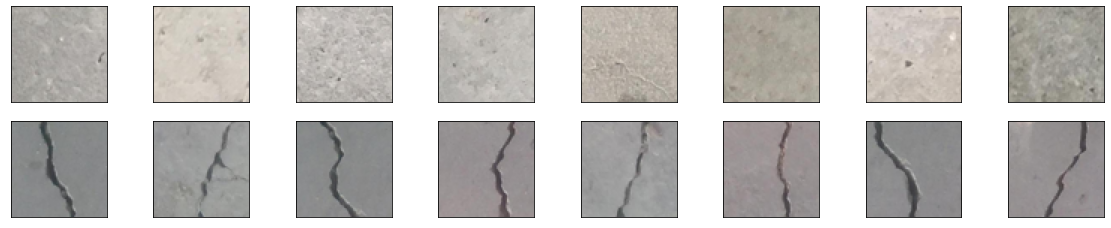

In [9]:
print("First row for normal imgs \nSecond row for cracked  imgs")
plot_two_pic_set(neg_img_list,pos_img_list)

# Part 2: Preprocessing Data

In [10]:
# shuffle data paths
random.seed(42)
random.shuffle(neg_img_paths)
random.shuffle(pos_img_paths)

In [11]:
# set train validation data set
x_train_neg = img_to_np(neg_img_paths[:1000])
x_train_neg = x_train_neg.astype(np.float32) / 255.

x_val_neg = img_to_np(neg_img_paths[1000:1200])
x_val_neg = x_val_neg.astype(np.float32) / 255.

x_val_pos = img_to_np(pos_img_paths[:200])
x_val_pos = x_val_pos.astype(np.float32) / 255.

print('X Train for neg shape:     ',x_train_neg.shape)
print('X Validation for neg shape:',x_val_neg.shape)
print('X Validation for pos shape:',x_val_pos.shape)

X Train for neg shape:      (1000, 64, 64, 3)
X Validation for neg shape: (200, 64, 64, 3)
X Validation for pos shape: (200, 64, 64, 3)


# Part 3: Build ConvAE model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, add
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D

In [13]:
x = Input(shape=(64, 64, 3)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0     

# Part 4: Train Model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF

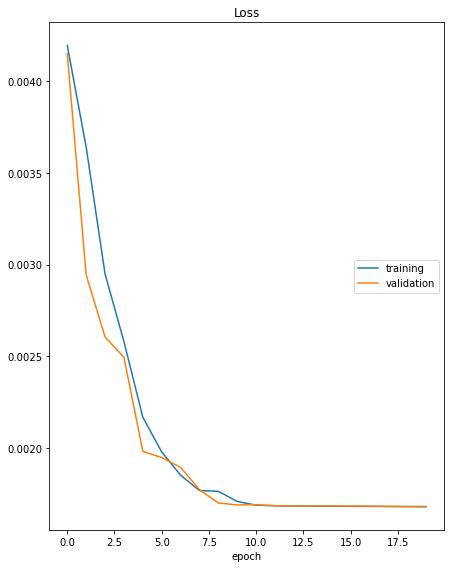

Loss
	training         	 (min:    0.002, max:    0.004, cur:    0.002)
	validation       	 (min:    0.002, max:    0.004, cur:    0.002)
Wall time: 55.2 s


In [20]:
%%time

epochs = 20
batch_size = 128
steps_per_epoch = 8

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("./models/scd_model.h5", monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = autoencoder.fit(
    x_train_neg, x_train_neg,
    steps_per_epoch = steps_per_epoch,
    validation_data = (x_val_neg, x_val_neg), 
    callbacks = callbacks,
    epochs = epochs)

# Part 4: Evaluate Model

First row for normal original imgs 
Second row for normal reconstuction imgs


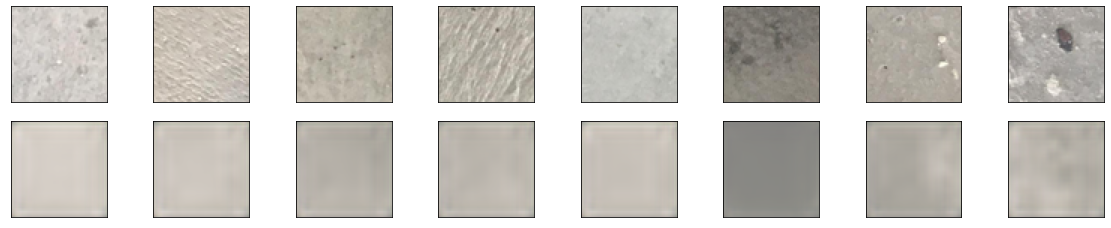

In [26]:
decoded_imgs_neg = autoencoder.predict(x_val_neg)
print("First row for normal original imgs \nSecond row for normal reconstuction imgs")
plot_two_pic_set(x_val_neg,decoded_imgs_neg)

First row for cracked original imgs 
Second row for cracked reconstuction imgs


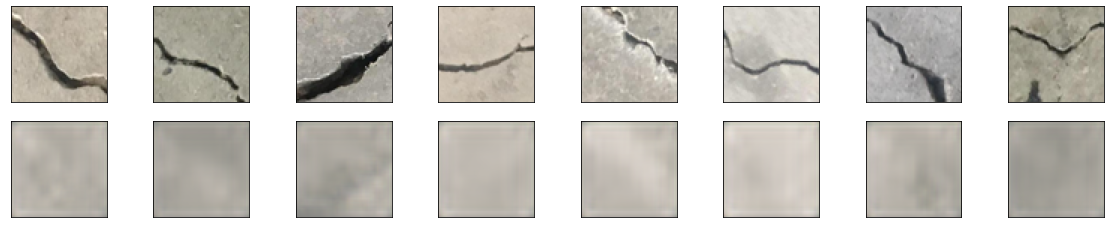

In [27]:
decoded_imgs_pos = autoencoder.predict(x_val_pos)
print("First row for cracked original imgs \nSecond row for cracked reconstuction imgs")
plot_two_pic_set(x_val_pos,decoded_imgs_pos)

In [29]:
x_val_neg[0].shape

(64, 64, 3)

In [ ]:
def get_mse_scores(model,x):
    sc = []
    for i in x :
        a = np.expand_dims(i,0)
        s = model.evaluate(a,a)
        sc.append(s)
    return sc

In [ ]:
mse_pos = get_mse_scores(autoencoder,x_val_p)
mse_neg = get_mse_scores(autoencoder,x_val)

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
y_true = np.array( [1] * 200 + [0] *200 )
y_prob = np.array(mse_pos + mse_neg)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)

# AUC
print("AUC reaches: ",metrics.auc(fpr, tpr))

# Print ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive rate')
plt.title('ROC curve')
plt.show() 

In [ ]:
metrics.auc(fpr, tpr)

# Part 5: Find Optimal Threshold

In [ ]:
threshold_evals = []
for threshold in thresholds:
    y_pred = (y_prob > threshold)
    precision,recall,F1,_ = precision_recall_fscore_support(y_true,y_pred,average = 'binary')
    threshold_evals.append([threshold,precision,recall,F1])

In [ ]:
df_threshold = pd.DataFrame(threshold_evals, columns = ['threshold','precision','recall','F1score'])

In [ ]:
df_threshold.sort_values('recall',ascending=False,inplace = True)

In [ ]:
df_threshold[['precision','recall']].plot()